In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [2]:
import sys
sys.path.append("..")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from common.utility import to_categorical, torch_device, load_processed_data
from notebook_utils.generate_gaussian import generate_gaussian
from notebook_utils.eigan import Encoder, Discriminator
from notebook_utils.federated import federated
from notebook_utils.eigan_training import distributed_3_diff, centralized_3
from notebook_utils.utility import class_plot, to_numpy
import notebook_utils.metrics as metrics

In [5]:
device='gpu'
device = torch_device(device=device)
device

device(type='cuda')

# Training

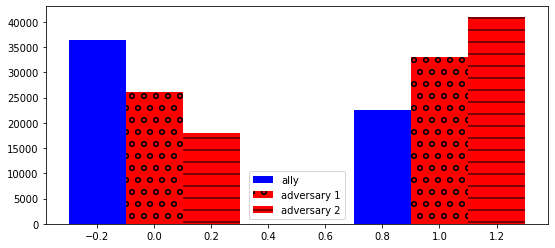

((58976, 168), (58976, 1), (58976, 1), (58976, 1))

In [6]:
X, y_ally, y_advr_1, y_advr_2 = pkl.load(
    open('../checkpoints/mimic/processed_data_X_y_ally_y_advr_y_advr_2.pkl', 'rb'))

y_ally = y_ally.reshape(-1, 1)
y_advr_1 = y_advr_1.reshape(-1, 1)
y_advr_2 = y_advr_2.reshape(-1, 1)


width=0.2
fig, (ax1) = plt.subplots(1, 1, figsize=(9, 4))
ax1.bar(np.unique(y_ally.flatten())-width, np.bincount(y_ally.flatten()), width, color='b')
ax1.bar(np.unique(y_advr_1.flatten()), np.bincount(y_advr_1.flatten()), width, color='r', hatch='o')
ax1.bar(np.unique(y_advr_2.flatten())+width, np.bincount(y_advr_2.flatten()), width, color='r', hatch='-')
ax1.legend(['ally', 'adversary 1', 'adversary 2'])

plt.show()

X.shape, y_ally.shape, y_advr_1.shape, y_advr_2.shape

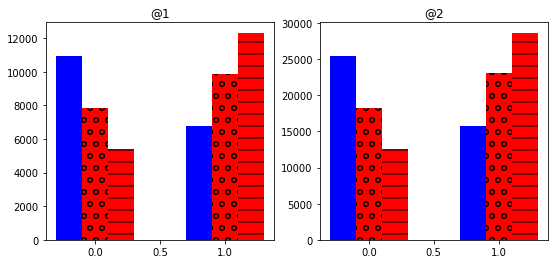

In [7]:
rand_idx = np.random.permutation(X.shape[0])
crossover = int(0.3*X.shape[0])

X1, X2 = X[rand_idx[:crossover]], X[rand_idx[crossover:]] 
y_ally_1, y_ally_2 = y_ally[rand_idx[:crossover]], y_ally[rand_idx[crossover:]]
y_advr_11, y_advr_12 = y_advr_1[rand_idx[:crossover]], y_advr_1[rand_idx[crossover:]]
y_advr_21, y_advr_22 = y_advr_2[rand_idx[:crossover]], y_advr_2[rand_idx[crossover:]]

width=0.2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.bar(np.unique(y_ally_1.flatten())-width, np.bincount(y_ally_1.flatten()), width, color='b')
ax1.bar(np.unique(y_advr_11.flatten()), np.bincount(y_advr_11.flatten()), width, color='r', hatch='o')
ax1.bar(np.unique(y_advr_21.flatten())+width, np.bincount(y_advr_21.flatten()), width, color='r', hatch='-')
ax1.set_title('@1')
ax2.bar(np.unique(y_ally_2.flatten())-width, np.bincount(y_ally_2.flatten()), width, color='b')
ax2.bar(np.unique(y_advr_12.flatten()), np.bincount(y_advr_12.flatten()), width, color='r', hatch='o')
ax2.bar(np.unique(y_advr_22.flatten())+width, np.bincount(y_advr_22.flatten()), width, color='r', hatch='-')
ax2.set_title('@2')
plt.show()

@node 0, X: (17692, 168), y_ally: (17692, 1), y_advr_1: (17692, 1), y_advr_2: (17692, 1)
@node 1, X: (41284, 168), y_ally: (41284, 1), y_advr_1: (41284, 1), y_advr_2: (41284, 1)
@node 0: X_train, X_valid, y_ally_train, y_ally_valid,y_advr_1_train, y_advr_1_valid, y_advr_2_train, y_advr_2_valid
(14153, 168) (3539, 168) (14153, 1) (3539, 1) (14153, 1) (3539, 1) (14153, 1) (3539, 1)
@node 0: class weights => w_ally, w_advr_1, w_advr_2 [array([1.62212034, 2.60740604])] [array([2.26086262, 1.79310782])] [array([3.29216097, 1.43626954])]
@node 0: tensor sizes => torch.Size([14153, 168]) (3539, 168) torch.Size([14153, 2]) (3539, 2) torch.Size([14153, 2]) (3539, 2) torch.Size([14153, 2]) (3539, 2)
@node 1: X_train, X_valid, y_ally_train, y_ally_valid,y_advr_1_train, y_advr_1_valid, y_advr_2_train, y_advr_2_valid
(33027, 168) (8257, 168) (33027, 1) (8257, 1) (33027, 1) (8257, 1) (33027, 1) (8257, 1)
@node 1: class weights => w_ally, w_advr_1, w_advr_2 [array([1.62212034, 2.60740604]), array([1.

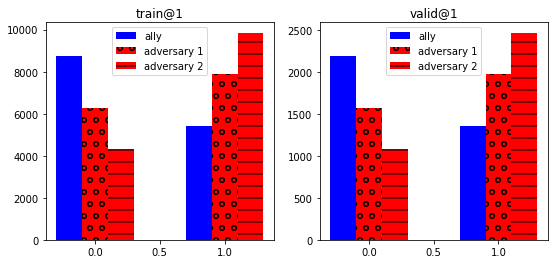

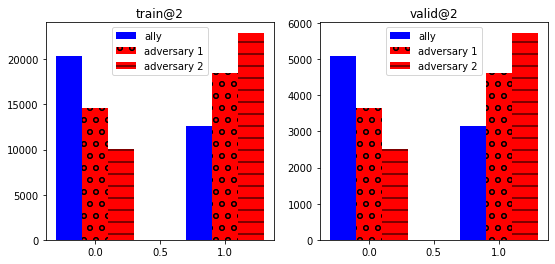

In [8]:
NUM_NODES = 2
BATCHSIZE = 512

X = [X1, X2] 
y_ally = [y_ally_1, y_ally_2]
y_advr_1 = [y_advr_11, y_advr_12]
y_advr_2 = [y_advr_21, y_advr_22]

for _ in range(NUM_NODES):
    print('@node {}, X: {}, y_ally: {}, y_advr_1: {}, y_advr_2: {}'.format(
        _, X[_].shape, y_ally[_].shape, y_advr_1[_].shape, y_advr_2[_].shape))
    
w_ally = []
w_advr_1 = []
w_advr_2 = []
train_loaders = []
X_valids = []
X_trains = []
y_ally_valids = []
y_ally_trains = []
y_advr_1_valids = []
y_advr_1_trains = []
y_advr_2_valids = []
y_advr_2_trains = []
for node_idx in range(NUM_NODES):
    X_local = X[node_idx]
    y_ally_local = y_ally[node_idx]
    y_advr_1_local = y_advr_1[node_idx]
    y_advr_2_local = y_advr_2[node_idx]
    
    X_train, X_valid, y_ally_train, y_ally_valid, \
    y_advr_1_train, y_advr_1_valid, \
    y_advr_2_train, y_advr_2_valid = train_test_split(
        X_local, y_ally_local, y_advr_1_local, y_advr_2_local, test_size=0.2, stratify=pd.DataFrame(
            np.concatenate((y_ally_local, y_advr_1_local, y_advr_2_local), axis=1)
        ))
    print('@node {}: X_train, X_valid, y_ally_train, y_ally_valid,'
          'y_advr_1_train, y_advr_1_valid, y_advr_2_train, y_advr_2_valid'.format(node_idx))
    print(X_train.shape, X_valid.shape, 
          y_ally_train.shape, y_ally_valid.shape,
          y_advr_1_train.shape, y_advr_1_valid.shape, 
          y_advr_2_train.shape, y_advr_2_valid.shape)

    w = np.bincount(y_ally_train.flatten())
    w_ally.append(sum(w)/w)
    w = np.bincount(y_advr_1_train.flatten())
    w_advr_1.append(sum(w)/w)
    w = np.bincount(y_advr_2_train.flatten())
    w_advr_2.append(sum(w)/w)
    print('@node {}: class weights => w_ally, w_advr_1, w_advr_2'.format(node_idx), w_ally, w_advr_1, w_advr_2)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    width = 0.2
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    ax1.bar(np.unique(
        y_ally_train.flatten())-width, np.bincount(y_ally_train.flatten()), width, color='b')
    ax1.bar(np.unique(
        y_advr_1_train.flatten()), np.bincount(y_advr_1_train.flatten()), width, color='r', hatch='o')
    ax1.bar(np.unique(
        y_advr_2_train.flatten())+width, np.bincount(y_advr_2_train.flatten()), width, color='r', hatch='-')
    ax1.legend(['ally', 'adversary 1', 'adversary 2'])
    ax1.set_title('train@{}'.format(node_idx+1))
    ax2.bar(np.unique(
        y_ally_valid.flatten())-width, np.bincount(y_ally_valid.flatten()), width, color='b')
    ax2.bar(np.unique(
        y_advr_1_valid.flatten()), np.bincount(y_advr_1_valid.flatten()), width, color='r', hatch='o')
    ax2.bar(np.unique(
        y_advr_2_valid.flatten())+width, np.bincount(y_advr_2_valid.flatten()), width, color='r', hatch='-')
    ax2.legend(['ally', 'adversary 1', 'adversary 2'])
    ax2.set_title('valid@{}'.format(node_idx+1))
    
    y_ally_train = to_categorical(y_ally_train)
    y_ally_valid = to_categorical(y_ally_valid)
    y_advr_1_train = to_categorical(y_advr_1_train)
    y_advr_2_train = to_categorical(y_advr_2_train)
    y_advr_1_valid = to_categorical(y_advr_1_valid)
    y_advr_2_valid = to_categorical(y_advr_2_valid)

    X_train = torch.Tensor(X_train)
    y_ally_train = torch.Tensor(y_ally_train)
    y_advr_1_train = torch.Tensor(y_advr_1_train)
    y_advr_2_train = torch.Tensor(y_advr_2_train)

    X_valids.append(torch.Tensor(X_valid))
    y_ally_valids.append(torch.Tensor(y_ally_valid))
    y_advr_1_valids.append(torch.Tensor(y_advr_1_valid))
    y_advr_2_valids.append(torch.Tensor(y_advr_2_valid))
    
    X_trains.append(X_train)
    y_ally_trains.append(y_ally_train)
    y_advr_1_trains.append(y_advr_1_train)
    y_advr_2_trains.append(y_advr_2_train)

    print('@node {}: tensor sizes =>'.format(node_idx), X_train.shape, X_valid.shape, 
          y_ally_train.shape, y_ally_valid.shape,
          y_advr_1_train.shape, y_advr_1_valid.shape, y_advr_2_train.shape, y_advr_2_valid.shape)

    train_loaders.append(DataLoader(TensorDataset(X_train, y_ally_train, y_advr_1_train, y_advr_2_train), 
                                    batch_size=BATCHSIZE, shuffle=True))
    

In [9]:
alpha = 1
lr_encd = 0.001
lr_ally = 0.001
lr_advr_1 = 0.001
lr_advr_2 = 0.001
n_iter_gan = 501

input_size = X_train.shape[1]
hidden_size = input_size*8
output_size = 2

In [10]:
global_params = {}
encoders = {}

In [11]:
history = {}
history = pkl.load(open('history_mimic_diff_sample_dist.pkl', 'rb'))

--------------------------------------------------------------------------------
EIGAN Training w/ phi=1.0 and delta=2
--------------------------------------------------------------------------------
epoch 	 node 	 encoder_train 	 encoder_valid 	 1_train 	 1_valid 	 2_train 	 2_valid 	 3_train 	 3_valid


/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:1334: UserWarning: This overload of add_ is deprecated:
add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
add_(Tensor other, Number alpha)
/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:1550: UserWarning: This overload of addcmul_ is deprecated:
addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
addcmul_(Tensor tensor1, Tensor tensor2, Number value)
/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:1480: UserWarning: This overload of addcdiv_ is deprecated:
addcdiv_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
addcdiv_(Tensor tensor1, Tensor tensor2, Number value)


0 	 0 	 0.39194936 	 0.41153079 	 0.65680450 	 0.67390376 	 0.96130049 	 0.95552015 	 0.00000000 	 0.00000000
0 	 1 	 0.33999640 	 0.37877321 	 0.59272867 	 0.61572343 	 0.00000000 	 0.00000000 	 0.93878669 	 0.93009740
Aggregating on epoch: 2...
Aggregating on epoch: 4...
Aggregating on epoch: 6...
Aggregating on epoch: 8...
Aggregating on epoch: 10...
Aggregating on epoch: 12...
Aggregating on epoch: 14...
Aggregating on epoch: 16...
Aggregating on epoch: 18...
Aggregating on epoch: 20...
20 	 0 	 0.26186353 	 0.35585308 	 0.51385045 	 0.61365676 	 0.94548821 	 0.95095086 	 0.00000000 	 0.00000000
20 	 1 	 0.32899541 	 0.36569959 	 0.58391231 	 0.59695798 	 0.00000000 	 0.00000000 	 0.94869888 	 0.92440557
Aggregating on epoch: 22...
Aggregating on epoch: 24...
Aggregating on epoch: 26...
Aggregating on epoch: 28...
Aggregating on epoch: 30...
Aggregating on epoch: 32...
Aggregating on epoch: 34...
Aggregating on epoch: 36...
Aggregating on epoch: 38...
Aggregating on epoch: 40...
40

320 	 1 	 0.31129307 	 0.43219477 	 0.52258903 	 0.65926278 	 0.00000000 	 0.00000000 	 0.92505974 	 0.92021519
Aggregating on epoch: 322...
Aggregating on epoch: 324...
Aggregating on epoch: 326...
Aggregating on epoch: 328...
Aggregating on epoch: 330...
Aggregating on epoch: 332...
Aggregating on epoch: 334...
Aggregating on epoch: 336...
Aggregating on epoch: 338...
Aggregating on epoch: 340...
340 	 0 	 0.50526518 	 0.53266406 	 0.77196491 	 0.78999460 	 0.96028459 	 0.95047772 	 0.00000000 	 0.00000000
340 	 1 	 0.29513168 	 0.40459788 	 0.55242181 	 0.63870150 	 0.00000000 	 0.00000000 	 0.95146149 	 0.92725080
Aggregating on epoch: 342...
Aggregating on epoch: 344...
Aggregating on epoch: 346...
Aggregating on epoch: 348...
Aggregating on epoch: 350...
Aggregating on epoch: 352...
Aggregating on epoch: 354...
Aggregating on epoch: 356...
Aggregating on epoch: 358...
Aggregating on epoch: 360...
360 	 0 	 0.25381213 	 0.41075999 	 0.49875677 	 0.67001885 	 0.94965100 	 0.9524060

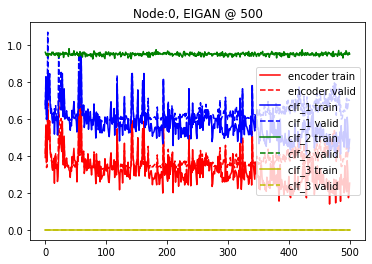

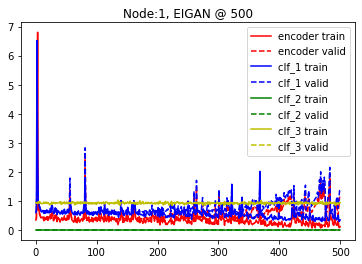

In [12]:
phi = 1.0
delta = 2
print("-"*80)
print('EIGAN Training w/ phi={} and delta={}'.format(phi, delta))
print("-"*80)
encoders['{}_{}'.format(phi, delta)] = distributed_3_diff(NUM_NODES, phi, delta, 
                       X_trains, X_valids, 
                       y_ally_train, y_ally_valids,                            
                       y_advr_1_trains, y_advr_1_valids,
                       y_advr_2_trains, y_advr_2_valids,
                       input_size, hidden_size, [2, 2, 2], 
                       alpha, lr_encd, lr_ally, lr_advr_1, lr_advr_2,w_ally, w_advr_1, w_advr_2,
                       train_loaders, n_iter_gan, device, global_params)

In [13]:
import pickle as pkl
pkl.dump(encoders, open('encoders_mimic_num_nodes_2.pkl', 'wb'))

In [ ]:
import pickle as pkl
encoders = pkl.load(open('encoders_mimic_num_nodes_2.pkl', 'rb'))

In [14]:
X_train = torch.cat(X_trains, dim=0).to(device)
X_valid = torch.cat(X_valids, dim=0).to(device)
y_ally_train = torch.cat(y_ally_trains, dim=0).to(device)
y_ally_valid = torch.cat(y_ally_valids, dim=0).to(device)
y_advr_1_train = torch.cat(y_advr_1_trains, dim=0).to(device)
y_advr_1_valid = torch.cat(y_advr_1_valids, dim=0).to(device)
y_advr_2_train = torch.cat(y_advr_2_trains, dim=0).to(device)
y_advr_2_valid = torch.cat(y_advr_2_valids, dim=0).to(device)

  0%|          | 0/501 [00:00<?, ?it/s]

epoch 	 encoder_train 	 encoder_valid 	 1_train 	 1_valid 	 2_train 	 2_valid 	 3_train 	 3_valid


  0%|          | 1/501 [00:02<24:31,  2.94s/it]

0 	 0.27133012 	 0.18883008 	 0.68463457 	 0.67657727 	 0.94715017 	 0.95171928 	 0.85930806 	 0.92232227


100%|██████████| 501/501 [24:11<00:00,  2.90s/it]

500 	 -0.31227016 	 5.99201155 	 0.08932392 	 6.47419453 	 0.93392253 	 0.95164031 	 0.95698869 	 0.91683710


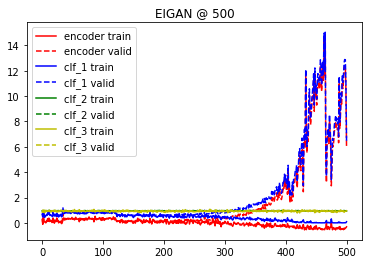

In [15]:
train_loader = DataLoader(TensorDataset(X_train, y_ally_train, y_advr_1_train, y_advr_2_train), batch_size=BATCHSIZE, shuffle=True)

encoder = centralized_3(X_train, X_valid,
                      y_ally_train, y_ally_valid,
                      y_advr_1_train, y_advr_1_valid,
                      y_advr_2_train, y_advr_2_valid,
                      input_size, hidden_size, [2, 2, 2],
                      alpha, lr_encd, lr_ally, lr_advr_1, lr_advr_2, w_ally[0], w_advr_1[0], w_advr_2[0],
                      train_loader, n_iter_gan, device)

In [16]:
import pickle as pkl
pkl.dump(encoder, open('encoder_mimic_num_nodes_2.pkl', 'wb'))

In [ ]:
import pickle as pkl
encoder = pkl.load(open('encoder_mimic_num_nodes_2.pkl', 'rb'))

In [17]:
history.keys()

dict_keys(['baseline_ally', 'baseline_advr_1', 'baseline_advr_2'])

In [18]:
print("-"*80)
print('ALLY: BASELINE')
print("-"*80)
history['baseline_ally'] = metrics.centralized(None, 
                                             input_size, hidden_size, output_size, 
                                             X_train, X_valid, y_ally_train, y_ally_valid, 
                                             w_ally[0], device, ['mlp', 'logistic'])

print("-"*80)
print('ADVERSARY 1: BASELINE')
print("-"*80)
history['baseline_advr_1'] = metrics.centralized(None, 
                                             input_size, hidden_size, output_size, 
                                             X_train, X_valid, y_advr_1_train, y_advr_1_valid, 
                                             w_advr_1[0], device, ['mlp', 'logistic'])

print("-"*80)
print('ADVERSARY 2: BASELINE')
print("-"*80)
history['baseline_advr_2'] = metrics.centralized(None, 
                                             input_size, hidden_size, output_size, 
                                             X_train, X_valid, y_advr_2_train, y_advr_2_valid, 
                                             w_advr_2[0], device, ['mlp', 'logistic'])

--------------------------------------------------------------------------------
ALLY: BASELINE
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.035742 	 1.035783 	 0.6123
200 	 0.432857 	 0.666977 	 0.7831
400 	 0.336006 	 0.830614 	 0.7575
600 	 0.286954 	 0.990090 	 0.7521
800 	 0.274243 	 1.232013 	 0.7698
1000 	 0.227628 	 1.276413 	 0.7431
Accuracy: 0.7644964394710071
Error Rate: 0.23550356052899288
F1 Score: 0.6780250347705146
Logistic Regression
--------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.7815361139369278
Error Rate: 0.21846388606307224
F1 Score: 0.7280211081794195
--------------------------------------------------------------------------------
ADVERSARY 1: BASELINE
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.036824 	 1.036809 	 0.5585
200 	 0.663190 	 1.121847 	 0.6095
400 	 0.572300 	 1.373985 	 0.6010
600 	 0.487031 	 1.569220 	 0.5948
800 	 0.410996 	 1.686545 	 0.5776
1000 	 0.401766 	 1.863652 	 0.5587
Accuracy: 0.5868090878263819
Error Rate: 0.4131909121736182
F1 Score: 0.6481374530753682
Logistic Regression
--------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.6129196337741607
Error Rate: 0.38708036622583925
F1 Score: 0.6658861407873555
--------------------------------------------------------------------------------
ADVERSARY 2: BASELINE
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.038434 	 1.038355 	 0.6952
200 	 0.525892 	 0.806980 	 0.7557
400 	 0.461998 	 0.996913 	 0.6983
600 	 0.413645 	 1.264326 	 0.7575
800 	 0.355384 	 1.395893 	 0.7575
1000 	 0.302390 	 1.509293 	 0.7510
Accuracy: 0.6901492031197016
Error Rate: 0.30985079688029843
F1 Score: 0.7617806165678159
Logistic Regression
--------------------------------------------------------------------------------
Accuracy: 0.7075279755849441
Error Rate: 0.29247202441505593
F1 Score: 0.7722772277227722


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [19]:
NUM_NODES = 2
X_trains = [_.to(device) for _ in X_trains]
X_valids = [_.to(device) for _ in X_valids]
y_ally_trains = [_.to(device) for _ in y_ally_trains]
y_ally_valids = [_.to(device) for _ in y_ally_valids]
y_advr_1_trains = [_.to(device) for _ in y_advr_1_trains]
y_advr_1_valids = [_.to(device) for _ in y_advr_1_valids]
y_advr_2_trains = [_.to(device) for _ in y_advr_2_trains]
y_advr_2_valids = [_.to(device) for _ in y_advr_2_valids]

In [20]:
print("-"*80)
print('ALLY: CENTRALIZED')
print("-"*80)
history['centralized_ally'] = metrics.centralized(encoder, 
                                             input_size, hidden_size, output_size, 
                                             X_train, X_valid, y_ally_train, y_ally_valid, 
                                             w_ally[0], device, ['mlp', 'logistic'])

print("-"*80)
print('ADVERSARY 1: CENTRALIZED')
print("-"*80)
history['centralized_advr_1'] = metrics.centralized(encoder, 
                                             input_size, hidden_size, output_size, 
                                             X_train, X_valid, y_advr_1_train, y_advr_1_valid, 
                                             w_advr_1[0], device, ['mlp', 'logistic'])

print("-"*80)
print('ADVERSARY 2: CENTRALIZED')
print("-"*80)
history['centralized_advr_2'] = metrics.centralized(encoder, 
                                             input_size, hidden_size, output_size, 
                                             X_train, X_valid, y_advr_2_train, y_advr_2_valid, 
                                             w_advr_2[0], device, ['mlp', 'logistic'])

--------------------------------------------------------------------------------
ALLY: CENTRALIZED
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.050586 	 1.047343 	 0.6140
200 	 0.136008 	 3.050239 	 0.7504
400 	 0.144188 	 3.246471 	 0.7575
600 	 0.124684 	 3.196027 	 0.7507
800 	 0.142327 	 3.071186 	 0.7579
1000 	 0.121991 	 2.819970 	 0.7475
Accuracy: 0.7556798914886402
Error Rate: 0.2443201085113598
F1 Score: 0.6777728085867621
Logistic Regression
--------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.7442353340115293
Error Rate: 0.25576466598847064
F1 Score: 0.6783239151295447
--------------------------------------------------------------------------------
ADVERSARY 1: CENTRALIZED
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.044830 	 1.045164 	 0.4471
200 	 0.896165 	 0.974136 	 0.5565
400 	 0.857011 	 1.053139 	 0.5556
600 	 0.828483 	 1.162611 	 0.5493
800 	 0.824319 	 1.277331 	 0.5249
1000 	 0.800439 	 1.328166 	 0.5498
Accuracy: 0.5397592404204815
Error Rate: 0.4602407595795185
F1 Score: 0.5707961103644557
Logistic Regression
--------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.5307731434384537
Error Rate: 0.4692268565615463
F1 Score: 0.5380956354836017
--------------------------------------------------------------------------------
ADVERSARY 2: CENTRALIZED
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.031014 	 1.030815 	 0.6556
200 	 0.826248 	 0.905718 	 0.7075
400 	 0.796797 	 0.998761 	 0.6757
600 	 0.780724 	 1.095355 	 0.6634
800 	 0.741019 	 1.168413 	 0.7057
1000 	 0.733836 	 1.290708 	 0.7102
Accuracy: 0.6791285181417429
Error Rate: 0.32087148185825703
F1 Score: 0.779235928842228
Logistic Regression
--------------------------------------------------------------------------------
Accuracy: 0.6145303492709393
Error Rate: 0.3854696507290607
F1 Score: 0.7086190323614227


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
for key, encd in encoders.items():
    print("-"*80)
    print('ALLY: {}'.format(key))
    print("-"*80)
    history['decentralize_ally_{}'.format(key)] = metrics.distributed(encd, NUM_NODES,
                                                         input_size, hidden_size, output_size, 
                                                         X_trains, X_valids, y_ally_trains, y_ally_valids, 
                                                         w_ally[0], device, ['mlp', 'logistic'])
    print("-"*80)
    print('ADVERSARY 1: {}'.format(key))
    print("-"*80)
    history['decentralized_advr_1_{}'.format(key)] = metrics.distributed(encd, NUM_NODES,
                                                                     input_size, hidden_size, output_size, 
                                                                     X_trains, X_valids, y_advr_1_trains, y_advr_1_valids, 
                                                                     w_advr_1[0], device, ['mlp', 'logistic'])
    
    print("-"*80)
    print('ADVERSARY: {}'.format(key))
    print("-"*80)
    history['decentralized_advr_2_{}'.format(key)] = metrics.distributed(encd, NUM_NODES,
                                                                     input_size, hidden_size, output_size, 
                                                                     X_trains, X_valids, y_advr_2_trains, y_advr_2_valids, 
                                                                     w_advr_2[0], device, ['mlp', 'logistic'])

--------------------------------------------------------------------------------
ALLY: 1.0_2
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.041863 	 1.041766 	 0.6170
200 	 0.352913 	 1.024729 	 0.7651
400 	 0.347121 	 1.127609 	 0.7655
600 	 0.346105 	 1.269893 	 0.7621
800 	 0.340668 	 1.332432 	 0.7651
1000 	 0.340452 	 1.427438 	 0.7658
Accuracy: 0.7616141064767717
Error Rate: 0.23838589352322823
F1 Score: 0.6951431049436253
Logistic Regression
--------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.7557646659884707
Error Rate: 0.24423533401152933
F1 Score: 0.6926277605889256
--------------------------------------------------------------------------------
ADVERSARY 1: 1.0_2
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.047662 	 1.047860 	 0.4785
200 	 0.941035 	 0.951548 	 0.5409
400 	 0.927024 	 0.960213 	 0.5608
600 	 0.918254 	 0.976499 	 0.5588
800 	 0.920014 	 0.991098 	 0.5529
1000 	 0.906580 	 0.998073 	 0.5552
Accuracy: 0.560528992878942
Error Rate: 0.43947100712105797
F1 Score: 0.6888728844076342
Logistic Regression
--------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.5322990844354019
Error Rate: 0.4677009155645982
F1 Score: 0.5380557648831953
--------------------------------------------------------------------------------
ADVERSARY: 1.0_2
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.049653 	 1.049639 	 0.6489
200 	 0.900024 	 0.910994 	 0.6769
400 	 0.886553 	 0.915078 	 0.6796
600 	 0.878702 	 0.927123 	 0.6735
800 	 0.883524 	 0.950016 	 0.6415
1000 	 0.860357 	 0.957341 	 0.6823
Accuracy: 0.6878602916242794
Error Rate: 0.3121397083757206
F1 Score: 0.8020642941619182
Logistic Regression
--------------------------------------------------------------------------------
Accuracy: 0.5592573753814852
Error Rate: 0.44074262461851477
F1 Score: 0.6399833806523093


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
history = pkl.load(open('history_mimic_diff_sample_dist.pkl', 'rb'))

In [22]:
pkl.dump(history, open('history_mimic_diff_sample_dist.pkl', 'wb'))

In [23]:
history.keys()

dict_keys(['baseline_ally', 'baseline_advr_1', 'baseline_advr_2', 'centralized_ally', 'centralized_advr_1', 'centralized_advr_2', 'decentralize_ally_1.0_2', 'decentralized_advr_1_1.0_2', 'decentralized_advr_2_1.0_2'])

0.7556798914886402


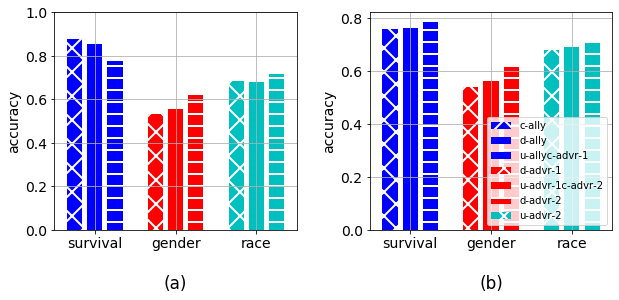

In [27]:
baseline_ally = []
baseline_advr_1 = []
baseline_advr_2 = []
eigan_ally = []
eigan_advr_1 = []
eigan_advr_2 = []
dist_x = []
dist_ally = []
dist_advr_1 = []
dist_advr_2 = []

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10, 4))

tmp = history['baseline_ally'][2]
baseline_ally.append(max(tmp['logistic'], tmp['mlp']))
tmp = history['baseline_advr_1'][2]
baseline_advr_1.append(max(tmp['logistic'], tmp['mlp']))
tmp = history['baseline_advr_2'][2]
baseline_advr_2.append(max(tmp['logistic'], tmp['mlp']))
tmp = history['centralized_ally'][2]
eigan_ally.append(max(tmp['logistic'], tmp['mlp']))
tmp = history['centralized_advr_1'][2]
eigan_advr_1.append(max(tmp['logistic'], tmp['mlp']))
tmp = history['centralized_advr_2'][2]
eigan_advr_2.append(max(tmp['logistic'], tmp['mlp']))

phi = 1.0
delta = 2
dist_x.append(phi)
tmp = history['decentralize_{}_{}_{}'.format('ally', phi, delta)][2]
dist_ally.append(max(tmp['logistic'], tmp['mlp']))
tmp = history['decentralized_{}_1_{}_{}'.format('advr', phi, delta)][2]
dist_advr_1.append(max(tmp['logistic'], tmp['mlp']))
tmp = history['decentralized_{}_2_{}_{}'.format('advr', phi, delta)][2]
dist_advr_2.append(max(tmp['logistic'], tmp['mlp']))

print(eigan_ally[0])
ax1.bar(0,eigan_ally[0], color='b', width=0.075, hatch='x')
ax1.bar(0.1, dist_ally, width=0.075, color='b')
ax1.bar(0.2, baseline_ally[0], width=0.075, color='b', hatch='-')


ax1.bar(0.4, eigan_advr_1[0], width=0.075, color='r', hatch = 'x')
ax1.bar(0.5, dist_advr_1, width=0.075, color='r')
ax1.bar(0.6, baseline_advr_1[0], width=0.075, color='r', hatch='-')


ax1.bar(0.8, eigan_advr_2[0], width=0.075, color='c', hatch = 'x')
ax1.bar(0.9, dist_advr_2, width=0.075, color='c')
ax1.bar(1.0, baseline_advr_2[0], width=0.075, color='c', hatch='-')

ax1.set_xticks(dist_x)
ax1.set_xlim(left=-0.1, right=1.1)
ax2.set_ylim(top=1.0, bottom=0)
ax1.legend(['c-ally', 'd-ally', 'u-ally' 'c-advr-1', 'd-advr-1', 'u-advr-1' 'c-advr-2', 'd-advr-2', 'u-advr-2']
          , prop={'size': 10}, loc='lower right')
# ax1.set_xlabel('fraction of parameters shared')
ax1.set_ylabel('accuracy')
ax1.set_title('(b)', y=-0.3)
ax1.grid()
ax1.set_xticks([0.1, 0.5, 0.9])
ax1.set_xticklabels(['survival', 'gender', 'race'])

baseline_ally = []
baseline_advr_1 = []
baseline_advr_2 = []
eigan_ally = []
eigan_advr_1 = []
eigan_advr_2 = []
dist_x = []
dist_ally = []
dist_advr_1 = []
dist_advr_2 = []

# normal training
b_ally = []
b_advr_1 = []
b_advr_2 = []
e_ally = []
e_advr_1 = []
e_advr_2 = []
d_x = []
d_ally = []
d_advr_1 = []
d_advr_2 = []
h = pkl.load(open('history_mimic_sample_dist.pkl', 'rb'))
tmp = h['baseline_ally'][2]
b_ally.append(max(tmp['logistic'], tmp['mlp']))
tmp = h['baseline_advr_1'][2]
b_advr_1.append(max(tmp['logistic'], tmp['mlp']))
tmp = h['baseline_advr_2'][2]
b_advr_2.append(max(tmp['logistic'], tmp['mlp']))
tmp = h['centralized_ally'][2]
e_ally.append(max(tmp['logistic'], tmp['mlp']))
tmp = h['centralized_advr_1'][2]
e_advr_1.append(max(tmp['logistic'], tmp['mlp']))
tmp = h['centralized_advr_2'][2]
e_advr_2.append(max(tmp['logistic'], tmp['mlp']))

phi = 1.0
delta = 2
d_x.append(phi)
tmp = h['decentralize_{}_{}_{}'.format('ally', phi, delta)][2]
d_ally.append(max(tmp['logistic'], tmp['mlp']))
tmp = h['decentralized_{}_1_{}_{}'.format('advr', phi, delta)][2]
d_advr_1.append(max(tmp['logistic'], tmp['mlp']))
tmp = h['decentralized_{}_2_{}_{}'.format('advr', phi, delta)][2]
d_advr_2.append(max(tmp['logistic'], tmp['mlp']))

ax2.bar(0,e_ally[0], color='b', width=0.075, hatch='x')
ax2.bar(0.1, d_ally, width=0.075, color='b')
ax2.bar(0.2, b_ally[0], width=0.075, color='b', hatch='-')


ax2.bar(0.4, e_advr_1[0], width=0.075, color='r', hatch = 'x')
ax2.bar(0.5, d_advr_1, width=0.075, color='r')
ax2.bar(0.6, b_advr_1[0], width=0.075, color='r', hatch='-')


ax2.bar(0.8, e_advr_2[0], width=0.075, color='c', hatch = 'x')
ax2.bar(0.9, d_advr_2, width=0.075, color='c')
ax2.bar(1.0, b_advr_2[0], width=0.075, color='c', hatch='-')

ax2.set_xticks(dist_x)
ax2.set_xlim(left=-0.1, right=1.1)
ax2.set_ylim(top=1.0, bottom=0)
# ax2.legend(['c-ally', 'd-ally', 'u-ally' 'c-advr-1', 'd-advr-1', 'u-advr-1' 'c-advr-2', 'd-advr-2', 'u-advr-2']
#           , prop={'size': 10}, loc='lower right')
# ax1.set_xlabel('fraction of parameters shared')
ax2.set_ylabel('accuracy')
ax2.set_title('(a)', y=-0.3)
ax2.grid()
ax2.set_xticks([0.1, 0.5, 0.9])
ax2.set_xticklabels(['survival', 'gender', 'race'])

plt.rcParams.update({'font.size': 14})
plt.rcParams['hatch.color'] = 'white'
plt.rcParams['hatch.linewidth'] = 2.0
fig.subplots_adjust(wspace=0.3)
plt.savefig('distributed_eigan_diff_mimic_comparison.png', bbox_inches='tight', dpi=300)

In [ ]:
e_ally[0]

In [ ]:
history['centralized_ally'][2]

In [ ]:
history['baseline_ally'][2]

In [ ]:
h['baseline_ally'][2]